# Binary Classification with ScikitLearn tools


In [1]:
from pprint import pprint
from time import time
import logging
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

import sklearn.cluster as cluster

from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

Automatically created module for IPython interactive environment


In [22]:
# Dimension reduction and clustering libraries
import umap
import hdbscan

# our modules
import text_processing
import file_import_helper
import plot_defs
# ensure modules are automatically reloaded after being modified
%load_ext autoreload
%autoreload 2
import exclude_remove

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
CPA = text_processing.fetch_files()
CPA.head()

2021-04-01 11:15:10,844 - text_processing - INFO - cleanded CPA File imported
2021-04-01 11:15:10,844 INFO cleanded CPA File imported
2021-04-01 11:15:10,869 INFO NumExpr defaulting to 4 threads.


,Order,Level,Code,Parent,Descr,Includes,Excludes,Exclusions_removed,Descr_old,Includes_old,Category_2,Category_3,Category_1,Category_0
0,1208792,1,A,NaN,"PRODUCTS OF AGRICULTURE, FORESTRY AND FISHING",NaN,NaN,NaN,"PRODUCTS OF AGRICULTURE, FORESTRY AND FISHING",NaN,NaN,NaN,A,1
1,1208793,2,01,A,"Products of agriculture, hunting and related s...",NaN,NaN,NaN,"Products of agriculture, hunting and related s...",NaN,01,NaN,A,1
2,1208794,3,01.1,01,Non-perennial crops,NaN,NaN,NaN,Non-perennial crops,NaN,01,01.1,A,1
3,1208795,4,01.11,01.1,"Cereals , leguminous crops and oil seeds","This class includes: cereals, leguminous crop...",NaN,NaN,"Cereals , leguminous crops and oil seeds","This class includes: cereals, leguminous crop...",01,01.1,A,1
4,1208796,5,01.11.1,01.11,Wheat,NaN,NaN,NaN,Wheat,NaN,01,01.1,A,1


## Vectorize with Scikit Learn
CountVectorizer implements both tokenization and occurrence counting in a single class

In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to use the tf–idf transform.

As tf–idf is very often used for text features, there is also another class called TfidfVectorizer that combines all the options of CountVectorizer and TfidfTransformer in a single model



In [4]:
tfidf_pipeline1 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])

In [5]:
# we apply the pipeline to "level 6" of the CPA datafame
df = CPA[CPA.Level==6].copy()

tfidf_pipeline1.fit(df.Descr)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer())])

# Reduce dimension - PCA 

**Principal Component Analysis**

2021-04-01 11:15:19,003 - text_processing - INFO - cleanded CPA File imported
2021-04-01 11:15:19,003 INFO cleanded CPA File imported


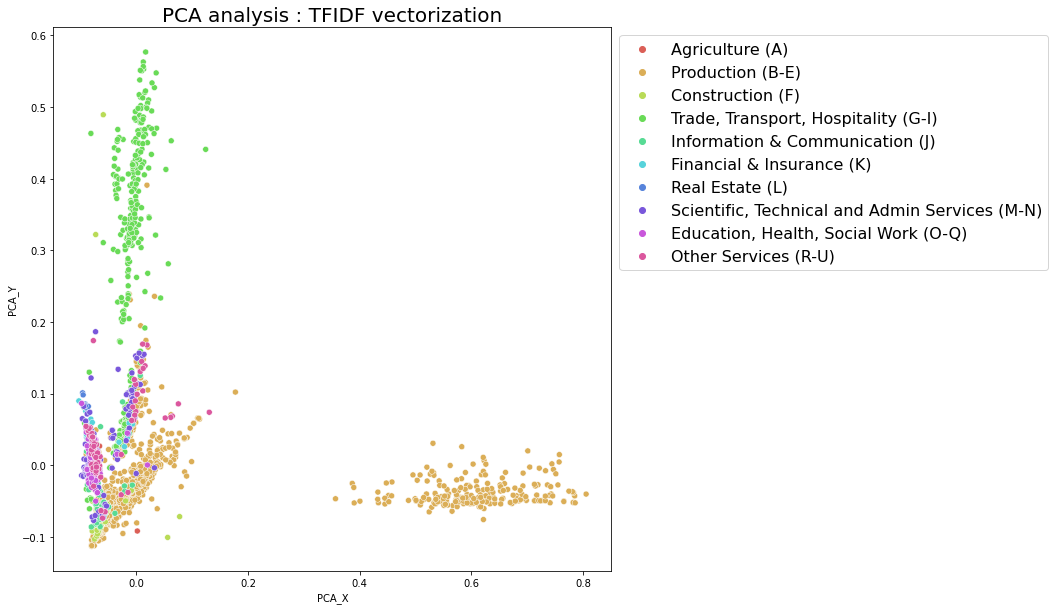

In [6]:
X = tfidf_pipeline1.transform(df.Descr).todense()
y = df.Category_1

# reduce dimension with PCA
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

PCA_df = df.copy()
PCA_df['PCA_X'] = X_r[:,0]
PCA_df['PCA_Y'] = X_r[:,1]

plot_defs.plot_scat(PCA_df, '0', 'PCA analysis : TFIDF vectorization')

# T-SNE visualisation

Adapted from: https://www.kaggle.com/premvardhan/amazon-fine-food-review-tsne-visualization

Not so good above 4 dimensions

In [7]:
X = tfidf_pipeline1.transform(df.Descr).todense()
y = df.Category_1


pca = PCA(n_components=10)
X_r = pca.fit(X).transform(X)

model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000, verbose=10)

tsne_data = model.fit_transform(X_r)

tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2"))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3218 samples in 0.005s...
[t-SNE] Computed neighbors for 3218 samples in 0.348s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3218
[t-SNE] Computed conditional probabilities for sample 2000 / 3218
[t-SNE] Computed conditional probabilities for sample 3000 / 3218
[t-SNE] Computed conditional probabilities for sample 3218 / 3218
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.414s
[t-SNE] Iteration 50: error = 74.4567032, gradient norm = 0.0474893 (50 iterations in 1.280s)
[t-SNE] Iteration 100: error = 65.5691376, gradient norm = 0.0076529 (50 iterations in 0.919s)
[t-SNE] Iteration 150: error = 64.8146057, gradient norm = 0.0063696 (50 iterations in 0.881s)
[t-SNE] Iteration 200: error = 64.5458374, gradient norm = 0.0025476 (50 iterations in 1.203s)
[t-SNE] Iteration 250: error = 64.4335938, gradient norm = 0.0016241 (50 iterations in 0.897s)
[t-SNE] KL divergence after 250 iterat

2021-04-01 11:17:16,289 - text_processing - INFO - cleanded CPA File imported
2021-04-01 11:17:16,289 INFO cleanded CPA File imported


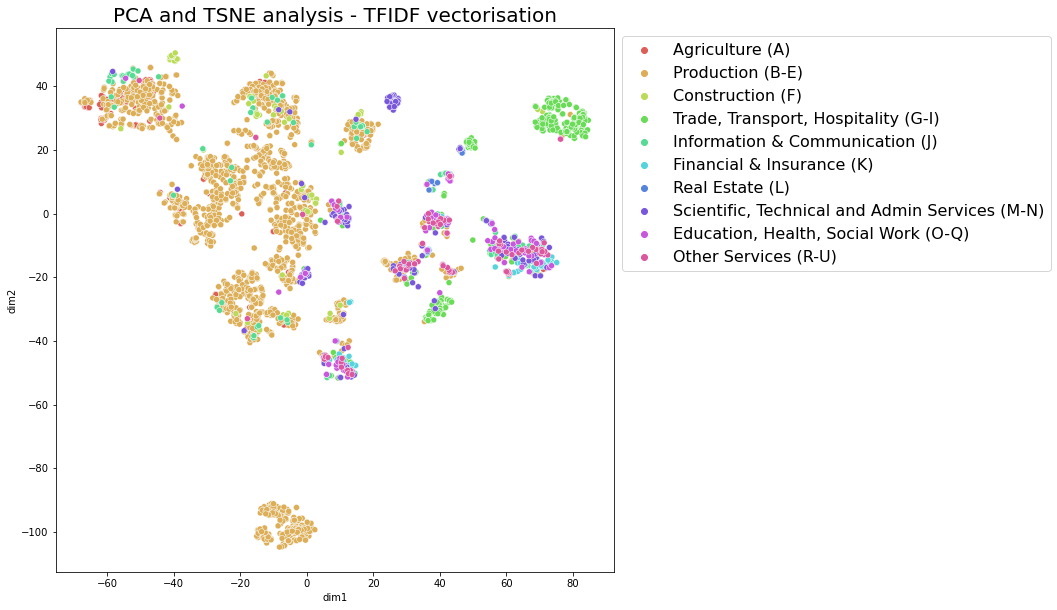

In [8]:
tsne_df2 = df.copy()
tsne_df2['dim1'] = tsne_data[:,0]
tsne_df2['dim2'] = tsne_data[:,1]
plot_defs.plot_scat(tsne_df2, '0', 'PCA and TSNE analysis - TFIDF vectorisation')

# Binary Classification

We use the following:  

    - from sklearn.ensemble import RandomForestClassifier
    - from sklearn.model_selection import train_test_split
    - from sklearn.model_selection import cross_val_predict
    - from sklearn.metrics import roc_curve
    - from sklearn.metrics import roc_auc_score

[Taken from O'Reilly "Hands on Machine Learning" Chapter 3](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch03.html)

### First we split our data into a test set and a training set, randomly allocating categories

In [11]:
train_set, test_set = train_test_split(tsne_df2, test_size=0.2, random_state=42)
train_set.head()

,Order,Level,Code,Parent,Descr,Includes,Excludes,Exclusions_removed,Descr_old,Includes_old,Category_2,Category_3,Category_1,Category_0,dim1,dim2
42,1208834,6,01.11.96,01.11.9,Castor oil seeds,NaN,NaN,NaN,Castor oil seeds,NaN,01,01.1,A,1,-58.924088,31.500860
4521,1213313,6,64.19.22,64.19.2,Consumer credit granting services by monetary ...,This subcategory includes: personal non-mort...,NaN,NaN,Consumer credit granting services by monetary ...,This subcategory includes: personal non-mort...,64,64.1,K,6,62.543781,-18.441320
34,1208826,6,01.11.81,01.11.8,Soya beans,NaN,This subcategory excludes: roasted soya beans...,NaN,Soya beans,NaN,01,01.1,A,1,-57.324947,36.535881
2680,1211472,6,28.24.99,28.24.9,Sub-contracted operations as part of manufactu...,NaN,NaN,NaN,Sub-contracted operations as part of manufactu...,NaN,28,28.2,C,2,-7.179970,-96.595238
1707,1210499,6,23.12.11,23.12.1,"Glass in sheets, bent, edge-worked, engraved, ...",NaN,NaN,NaN,"Glass in sheets, bent, edge-worked, engraved, ...",NaN,23,23.1,C,2,13.552819,25.295584


## Now train a binary classifier - Random forest classifier
This will take each entry in Category_0 (1 to 10) in turn and apply train a binary classifier : this class vs all the others

We use the RandomForestClassifier with cros_val_predict 

In [30]:
def binary_cl(X_train, forest_clf, cat):
    y_train=(train_set.Category_0==cat)
  #  y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3,  method="predict_proba")
    y_scores = cross_val_predict(forest_clf, X_train, y_train, cv=3, method='predict_proba')
   #  score = roc_auc_score(y_train, y_scores[:,1])
    score = roc_auc_score(y_train, y_scores)
    return score
 
X_train = train_set[['dim1','dim2']]
forest_clf = RandomForestClassifier(random_state=42)



In [31]:
for cat in range (1,11):
    tmp_score = binary_cl(X_train, forest_clf, cat)
    print(f'Category {cat} roc_auc score :', round(tmp_score,4))



ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [14]:
y_train_BE = (train_set.Category_0==2)
y_scores = cross_val_predict(forest_clf, X_train, y_train_BE, cv=3, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y_train_BE, y_scores[:,1])

IndexError: index 1 is out of bounds for axis 1 with size 1

In [19]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 8))                         # Not shown
plot_roc_curve(fpr, tpr)

#save_fig("roc_curve_plot")                         # Not shown
plt.show()

NameError: name 'fpr' is not defined

<Figure size 576x576 with 0 Axes>